In [1]:
# Importing the necessary dependency libraries
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import shap
import imblearn
from imblearn.over_sampling import SMOTE

In [2]:
# Define model performance test functions
def mlperformance(rf, xtrain_up, ytrain_up, x_train, y_train):
    # fit modle
    rf.fit(xtrain_up, ytrain_up);
    # AUC
    auc_scores = roc_auc_score(y_train, rf.predict_proba(x_train)[:,1])
    print('auc = ', "%.3f"%auc_scores)
    # accuracy
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_train, rf.predict(x_train))*100
    print('accuracy = ', "%.1f"%accuracy)
    print('------------------------')
    # Confusion matrix
    import sklearn.metrics as sm
    from sklearn.metrics import confusion_matrix
    matrix = confusion_matrix(y_train, rf.predict(x_train), labels=None, sample_weight=None)
    print('混淆矩阵为：')
    print(matrix)
    (tn,fp,fn,tp) = matrix.ravel()
    print('tn=',tn)
    print('fp=',fp)
    print('fn=',fn)
    print('tp=',tp)
    print('------------------------')
    sensitivity = (tp/(tp+fn))*100
    specificity = (tn/(fp+tn))*100
    PPV=tp/(tp+fp)*100
    NPV=tn/(fn+tn)*100
    print(f'PPV = {"%.1f"%PPV}\n({tp}/{(tp+fp)})')
    print(f'NPV = {"%.1f"%NPV}\n({tn}/{(fn+tn)})')
    print(f'sensitivity = {"%.1f"%sensitivity}\n({tp}/{(tp+fn)})')
    print(f'specificity = {"%.1f"%specificity}\n({tn}/{(fp+tn)})')

In [3]:
# Reading data
train = pd.read_csv('F:/Onedrive/JIMMY/Python/Notebook/data_set/inuse/train.csv',encoding='gbk')
test = pd.read_csv('F:/Onedrive/JIMMY/Python/Notebook/data_set/inuse/test.csv',encoding='gbk')
validation = pd.read_csv('F:/Onedrive/JIMMY/Python/Notebook/data_set/inuse/validation_new04.csv',encoding='gbk')

xtrain = train.iloc[:,9:14]
xtest = test.iloc[:,9:14]
xv = validation.iloc[:,9:14]
ytrain = train.iloc[:,-1]
ytest = test.iloc[:,-1]
yv = validation.iloc[:,-1]

# Up-sampling processing
sm = SMOTE(sampling_strategy={1: 2700},random_state=100) 
xtrainup,ytrainup = sm.fit_resample(xtrain,ytrain)

After over-sampling, the number of samples (2700) in class 1 will be larger than the number of samples in the majority class (class #0 -> 1582)


In [4]:
# Model Instantiation
rf = RandomForestClassifier(n_estimators=275,
                             max_depth=7,
                             min_samples_leaf=1,
                             min_samples_split=6,
                             max_features=1,
                             random_state=224,
                             n_jobs=-1)

In [5]:
# Testing the model on the training set
mlperformance(rf, xtrainup, ytrainup, xtrain, ytrain)

auc =  0.922
accuracy =  83.7
------------------------
混淆矩阵为：
[[1271  311]
 [  42  544]]
tn= 1271
fp= 311
fn= 42
tp= 544
------------------------
PPV = 63.6
(544/855)
NPV = 96.8
(1271/1313)
sensitivity = 92.8
(544/586)
specificity = 80.3
(1271/1582)


In [6]:
# Calculate SHAP values to understand the detailed diagnostic basis of the model
shap.initjs()
explainer=shap.TreeExplainer(rf)
shap_values = explainer.shap_values(xtrain)
expected_value= explainer.expected_value

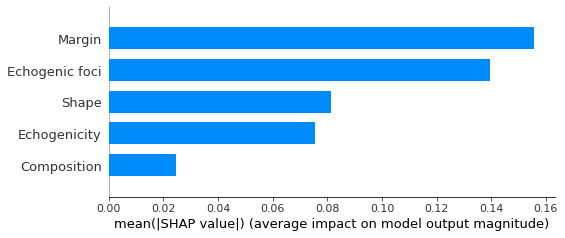

In [7]:
shap.summary_plot(shap_values[1], xtrain, plot_type="bar")

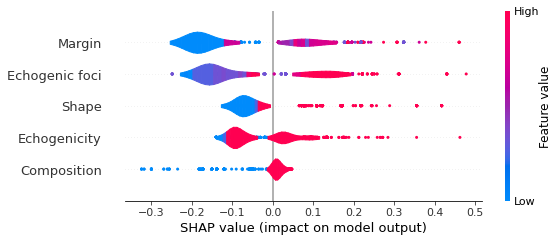

In [8]:
shap.summary_plot(shap_values[1], xtrain, plot_type="violin")

In [9]:
shap.force_plot(expected_value[1], shap_values[1],xtrain)

In [11]:
# Testing the model on the internal validation set
mlperformance(rf, xtrainup, ytrainup, xtest, ytest)

auc =  0.905
accuracy =  82.7
------------------------
混淆矩阵为：
[[531 135]
 [ 26 238]]
tn= 531
fp= 135
fn= 26
tp= 238
------------------------
PPV = 63.8
(238/373)
NPV = 95.3
(531/557)
sensitivity = 90.2
(238/264)
specificity = 79.7
(531/666)


In [12]:
# Calculate SHAP values to understand the detailed diagnostic basis of the model
shap.initjs()
#计算shap值
explainer=shap.TreeExplainer(rf)
shap_values = explainer.shap_values(xtest)
expected_value= explainer.expected_value

In [13]:
shap.force_plot(expected_value[1], shap_values[1], xtest)

In [14]:
# Testing the model on the external validation set
mlperformance(rf, xtrainup, ytrainup, xv, yv)

auc =  0.892
accuracy =  82.8
------------------------
混淆矩阵为：
[[504 128]
 [ 21 214]]
tn= 504
fp= 128
fn= 21
tp= 214
------------------------
PPV = 62.6
(214/342)
NPV = 96.0
(504/525)
sensitivity = 91.1
(214/235)
specificity = 79.7
(504/632)


In [15]:
# Calculate SHAP values to understand the detailed diagnostic basis of the model
shap.initjs()
explainer=shap.Explainer(rf)
shap_values = explainer.shap_values(xv)
expected_value= explainer.expected_value

In [16]:
shap.force_plot(expected_value[1], shap_values[1],xv)

The true label of patient 157 is False, the model prediction is 0.14,TIRADS_LEVEL is 3.0


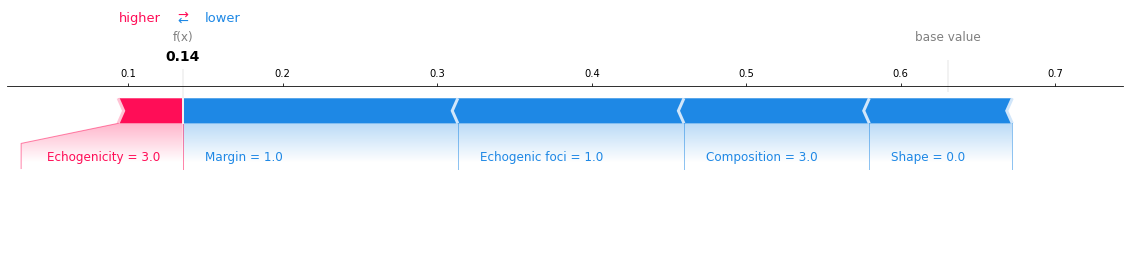

In [17]:
idx=157
idx_validation = validation.iloc[idx,: ]
patient =xv.iloc[idx,: ]
patient_df =xv.loc[idx:idx]
model_predict_proba =rf.predict_proba(patient_df)[0][1]
print('The true label of patient {} is {}, the model prediction is {:.2f}, TIRADS_LEVEL is {}'.format(idx,bool(yv[idx]), model_predict_proba, idx_validation['TIRADS_LEVEL']))
shap_values_patient=explainer.shap_values(patient)
shap.force_plot(explainer.expected_value[1], shap_values_patient[1],patient,matplotlib=True)

The true label of patient 3 is True, the model prediction is 0.88,TIRADS_LEVEL is 5.0


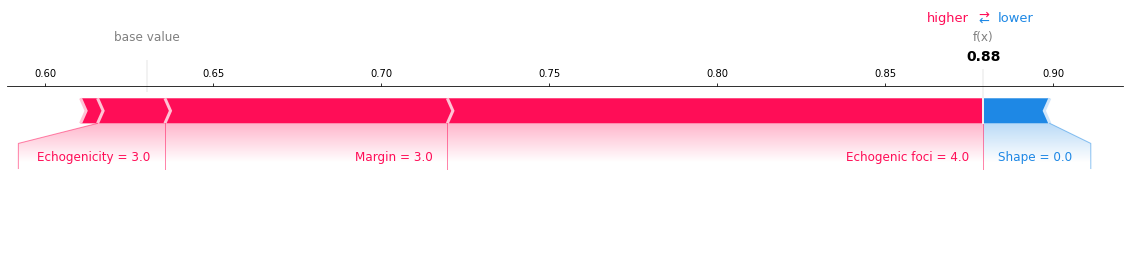

In [18]:
idx=3
idx_validation = validation.iloc[idx,: ]
patient =xv.iloc[idx,: ]
patient_df =xv.loc[idx:idx]
model_predict_proba =rf.predict_proba(patient_df)[0][1]
print('The true label of patient {} is {}, the model prediction is {:.2f}, TIRADS_LEVEL is {}'.format(idx,bool(yv[idx]), model_predict_proba, idx_validation['TIRADS_LEVEL']))
shap_values_patient=explainer.shap_values(patient)
shap.force_plot(explainer.expected_value[1], shap_values_patient[1],patient,matplotlib=True)

The true label of patient 866 is True, the model prediction is 0.77,TIRADS_LEVEL is 2.0


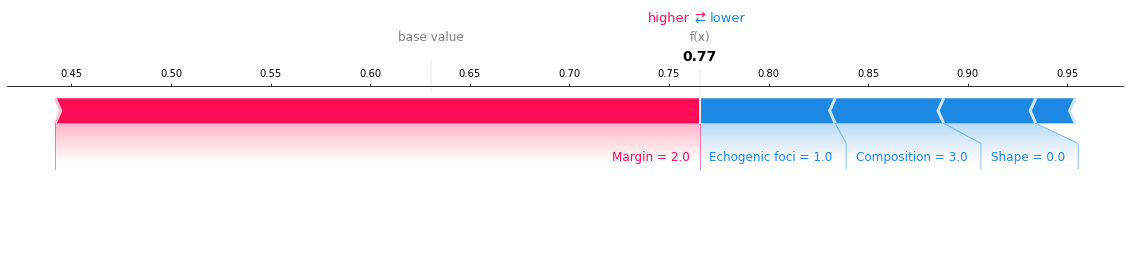

In [19]:
idx=866
idx_validation = validation.iloc[idx,: ]
patient =xv.iloc[idx,: ]
patient_df =xv.loc[idx:idx]
model_predict_proba =rf.predict_proba(patient_df)[0][1]
print('The true label of patient {} is {}, the model prediction is {:.2f}, TIRADS_LEVEL is {}'.format(idx,bool(yv[idx]), model_predict_proba, idx_validation['TIRADS_LEVEL']))
shap_values_patient=explainer.shap_values(patient)
shap.force_plot(explainer.expected_value[1], shap_values_patient[1],patient,matplotlib=True)

The true label of patient 105 is False, the model prediction is 0.21,TIRADS_LEVEL is 4.0


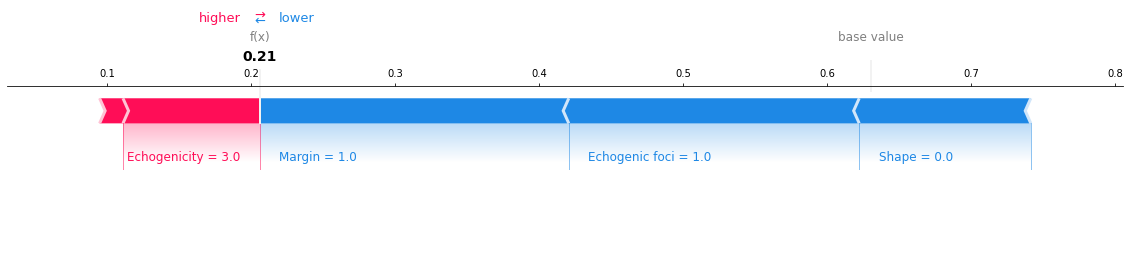

In [20]:
idx=105
idx_validation = validation.iloc[idx,: ]
patient =xv.iloc[idx,: ]
patient_df =xv.loc[idx:idx]
model_predict_proba =rf.predict_proba(patient_df)[0][1]
print('The true label of patient {} is {}, the model prediction is {:.2f}, TIRADS_LEVEL is {}'.format(idx,bool(yv[idx]), model_predict_proba, idx_validation['TIRADS_LEVEL'],idx_validation['Section']))
shap_values_patient=explainer.shap_values(patient)
shap.force_plot(explainer.expected_value[1], shap_values_patient[1],patient,matplotlib=True)